In [139]:
# first compute all the kernel derivatives
import sympy as sym

x = sym.Symbol('x')
xp = sym.Symbol('xp')
L = sym.Symbol('L')

kernel = sym.exp(-0.5 / L / L * (x - xp)**2)
print(f"{kernel=}")

lapl2_kernel = kernel.diff(x, x)
print(f"{lapl2_kernel=}")

lapl4_kernel = kernel.diff(x, x, x, x)
print(f"{lapl4_kernel=}")

lapl6_kernel = kernel.diff(x, x, x, x, xp, xp)
print(f"{lapl6_kernel=}")

lapl8_kernel = kernel.diff(x, x, x, x, xp, xp, xp, xp)
print(f"{lapl8_kernel=}")

kernel=exp(-0.5*(x - xp)**2/L**2)
lapl2_kernel=1.0*(-1 + (x - xp)**2/L**2)*exp(-0.5*(x - xp)**2/L**2)/L**2
lapl4_kernel=(3.0 - 6.0*(x - xp)**2/L**2 + 1.0*(x - xp)**4/L**4)*exp(-0.5*(x - xp)**2/L**2)/L**4
lapl6_kernel=(-15.0 + 45.0*(x - xp)**2/L**2 - 15.0*(x - xp)**4/L**4 + 1.0*(x - xp)**6/L**6)*exp(-0.5*(x - xp)**2/L**2)/L**6
lapl8_kernel=(105.0 - 420.0*(x - xp)**2/L**2 + 210.0*(x - xp)**4/L**4 - 28.0*(x - xp)**6/L**6 + 1.0*(x - xp)**8/L**8)*exp(-0.5*(x - xp)**2/L**2)/L**8


Or in other words, if in 2D kernel k(x,x') = k_x * k_y we have in each 1D direction:
$$ k_x = exp(-1/2 * \frac{(x-x')^2}{L_x^2}) = exp(-0.5 \overline{x}^2) $$
where $\overline{x} = (x-x')/L_x$.
Then the derivative of this 1D kernel are from above:
$$ k_x = exp(-1/2 \cdot \overline{x}^2) $$
$$ \partial_x^2 k_x = L_x^{-2} (-1 + \overline{x}^2) k_x $$
$$ \partial_x^4 k_x = L_x^{-4} (3 -6 \overline{x}^2 + \overline{x}^4) k_x $$

So in 2D if $K = k_x \cdot k_y$ then we have the following Laplacian:
$$ \nabla_x^4 K = \partial_x^4 k_x k_y + 2 \partial_x^2 k_x \partial_y^2 k_y + \partial_y^4 k_y $$

# Optimization problem in RKHS (Reproducing Kernel Hilbert Space)
Now we have the discrete kernel function $K(x,x')$ certainly, but in function space there is also an inner product on the kernel $K$ which is:
$$ <\phi, \psi>_K = \int K(x,x') \phi(x) \psi(x') dx dx' $$
The norm in the RKHS of a function w(x) is also:
$$ |w(x)|_K = \sqrt{<w, Kw>} = \sqrt{\int K(x,x') w(x) w(x') dx dx'} $$
More details included in the overleaf. Going to proceed into doing the analysis and constructing the kernel matrix.

In [140]:
# panel linear static inputs
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)

# choose loading type (first just uniaxial loading in x-direction)
# axial = True
axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# a, b = (1, 1)
(a, b) = (3, 1)

def q_load(x,y): # distributed load across the panel
    return 1.0

type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


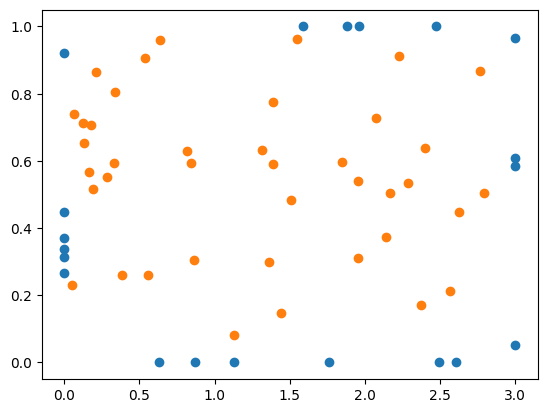

In [ ]:
# compute the linear static analysis inputs and mesh domain of collocation pts
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# case = 'low'
case = 'medium'
# case = 'high'

if case == 'high':
    num_domain = 500
    num_bndry = 100
    num_test = 50
elif case == 'medium':
    num_domain = 40
    num_bndry = 10
    num_test = 50
elif case == 'low':
    num_domain = 10
    num_bndry = 5
    num_test = 5

# num_domain = 1000
# need lower numbers first since this is a dense matrix..
# num_domain = 100
# num_bndry = 40
# num_test = 50




num_interior = num_domain



DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
N_b = num_bndry
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:,0], x_train[:,1]) # only show 1000 of the points
plt.show()

# q vector
_temp = np.array([q_load(x[i], y[i]) for i in range(num_domain)])
q = tf.constant(_temp, shape=(num_domain,1), dtype=DTYPE)

In [142]:
# define the kernel functions and cross-covariance kernel functions between w and its derivatives
# compute block matrix now

# hyperparameter here (could include in optimization as well later)
Lx = 1.0
Ly = 1.0

def kernel1d(x,xp,L):
    xbar = (x - xp) / L
    return np.exp(-0.5 * xbar**2)

def kernel1d_d2(x,xp,L):
    xbar = (x-xp)/L
    return L**(-2.0) * (-1.0 + xbar**2) * kernel1d(x,xp,L)

def kernel1d_d4(x,xp,L):
    xbar = (x-xp)/L
    return L**(-4.0) * (3.0 - 6.0 * xbar**2 + xbar**4) * kernel1d(x,xp,L)

def kernel1d_d6(x,xp,L):
    xbar = (x-xp)/L
    return L**(-6.0) * (-15 + 45 * xbar**2 - 15 * xbar**4 + xbar**6) * kernel1d(x,xp,L)

def kernel1d_d8(x,xp,L):
    xbar = (x-xp)/L
    return L**(-8.0) * (105 - 420 * xbar**2 + 210 * xbar**4 - 28 * xbar**6 + xbar**8) * kernel1d(x,xp,L)

def kernel2d(x,xp):
    return kernel1d(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly)

def kernel2d_bilapl(x,xp):
    return kernel1d_d4(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly) + \
           2.0 * kernel1d_d2(x[0], xp[0], Lx) * kernel1d_d2(x[1], xp[1], Ly) + \
           kernel1d(x[0], xp[0], Lx) * kernel1d_d4(x[1], xp[1], Ly)

def kernel2d_double_bilapl(x,xp):
    # nabla_x^4 * nabla_x'^4 exapnds into 16 terms
    return kernel1d_d8(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly) + \
           4.0 * kernel1d_d6(x[0], xp[0], Lx) * kernel1d_d2(x[1], xp[1], Ly) + \
           6.0 * kernel1d_d4(x[0], xp[0], Lx) * kernel1d_d4(x[1], xp[1], Ly) + \
           4.0 * kernel1d_d2(x[0], xp[0], Lx) * kernel1d_d6(x[1], xp[1], Ly) + \
           kernel1d(x[0], xp[0], Lx) * kernel1d_d8(x[1], xp[1], Ly)

In [143]:
# verify the kernel function derivatives with tensorflow gradient taping..
import numpy as np
import tensorflow as tf
xy = np.random.rand(2)
x = tf.constant(xy[0:1]); y = tf.constant(xy[1:2])
# temp = tf.concat([x, y], axis=0)
xyp = tf.constant(np.random.rand(2))
xp = tf.constant(xyp[0:1]); yp = tf.constant(xyp[1:2])

def kernel1d_tf(x,xp,L):
    xbar = (x - xp) / L
    return tf.exp(-0.5 * tf.pow(xbar, 2.0))

L_tf = tf.constant(np.array([Lx, Ly]))
# print(f"{L_tf=} {xyp2=}")
def kernel2d_tf(x, xp):
    xbar = (x - xp) / L_tf
    return tf.exp(-0.5 * tf.reduce_sum(tf.pow(xbar, 2.0)))

with tf.GradientTape(persistent=True) as tape4:
    tape4.watch(x)
    tape4.watch(y)
    with tf.GradientTape(persistent=True) as tape3:
        tape3.watch(x)
        tape3.watch(y)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            tape2.watch(y)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(x)
                tape1.watch(y)
                K = kernel2d_tf(tf.concat([x, y], axis=0), xyp)
                dKdx = tape1.gradient(K, x)
                dKdy = tape1.gradient(K, y)
                # print(f"{K=} {dKdx=} {dKdy=}")
            dx2 = tape2.gradient(dKdx, x)
            dy2 = tape2.gradient(dKdy, y)
            # print(f"{dx2=} {dy2=}")
        dx3 = tape3.gradient(dx2, x)
        dxxy = tape3.gradient(dx2, y)
        dy3 = tape3.gradient(dy2, y)
    dx4 = tape4.gradient(dx3, x)
    dx2y2 = tape4.gradient(dxxy, y)
    dy4 = tape4.gradient(dy3, y)

del tape1, tape2, tape3, tape4

# the nabla^4_x k_x for 2d kernel seems to be correct!
tf_bilapl_x = (dx4 + 2.0 * dx2y2 + dy4).numpy()[0]
print(f"{tf_bilapl_x=}")
analytic_bilapl_x = kernel2d_bilapl(xy, xyp).numpy()
print(f"{analytic_bilapl_x=}")
bilapl_rel_err = np.abs((tf_bilapl_x - analytic_bilapl_x) / tf_bilapl_x)
print(f"{bilapl_rel_err=}")

# now check the bilaplacian with 8th order derivatives..
# namely nabla_x^4 \odot nabla_{x'}^4 \odot K(x,x') with x,x' in R^2
with tf.GradientTape(persistent=True) as tape8:
    tape8.watch(xp)
    tape8.watch(yp)
    with tf.GradientTape(persistent=True) as tape7:
        tape7.watch(xp)
        tape7.watch(yp)
        with tf.GradientTape(persistent=True) as tape6:
            tape6.watch(xp)
            tape6.watch(yp)
            with tf.GradientTape(persistent=True) as tape5:
                tape5.watch(xp)
                tape5.watch(yp)
                with tf.GradientTape(persistent=True) as tape4:
                    tape4.watch(x)
                    tape4.watch(y)
                    with tf.GradientTape(persistent=True) as tape3:
                        tape3.watch(x)
                        tape3.watch(y)
                        with tf.GradientTape(persistent=True) as tape2:
                            tape2.watch(x)
                            tape2.watch(y)
                            with tf.GradientTape(persistent=True) as tape1:
                                tape1.watch(x)
                                tape1.watch(y)
                                K = kernel2d_tf(tf.concat([x, y], axis=0), tf.concat([xp, yp], axis=0))
                                dKdx = tape1.gradient(K, x)
                                dKdy = tape1.gradient(K, y)
                                # print(f"{K=} {dKdx=} {dKdy=}")
                            dx2 = tape2.gradient(dKdx, x)
                            dy2 = tape2.gradient(dKdy, y)
                            # print(f"{dx2=} {dy2=}")
                        dx3 = tape3.gradient(dx2, x)
                        dxxy = tape3.gradient(dx2, y)
                        dy3 = tape3.gradient(dy2, y)
                    dx4 = tape4.gradient(dx3, x)
                    dx2y2 = tape4.gradient(dxxy, y)
                    dy4 = tape4.gradient(dy3, y)
                dxp_dx4 = tape5.gradient(dx4, xp)
                dxp_dx2y2 = tape5.gradient(dx2y2, xp)
                dxp_dy4 = tape5.gradient(dy4, xp)
                dyp_dx4 = tape5.gradient(dx4, yp)
                dyp_dx2y2 = tape5.gradient(dx2y2, yp)
                dyp_dy4 = tape5.gradient(dy4, yp)
            dxp2_dx4 = tape6.gradient(dxp_dx4,xp)
            dyp2_dx4 = tape6.gradient(dyp_dx4, yp)
            dxp2_dx2y2 = tape6.gradient(dxp_dx2y2,xp)
            dyp2_dx2y2 = tape6.gradient(dyp_dx2y2, yp)
            dxp2_dy4 = tape6.gradient(dxp_dy4,xp)
            dyp2_dy4 = tape6.gradient(dyp_dy4, yp)
        dxp3_dx4 = tape7.gradient(dxp2_dx4, xp)
        dxpxpyp_dx4 = tape7.gradient(dxp2_dx4, yp)
        dyp3_dx4 = tape7.gradient(dyp2_dx4, yp)
        dxp3_dx2y2 = tape7.gradient(dxp2_dx2y2, xp)
        dxpxpyp_dx2y2 = tape7.gradient(dxp2_dx2y2, yp)
        dyp3_dx2y2 = tape7.gradient(dyp2_dx2y2, yp)
        dxp3_dy4 = tape7.gradient(dxp2_dy4, xp)
        dxpxpyp_dy4 = tape7.gradient(dxp2_dy4, yp)
        dyp3_dy4 = tape7.gradient(dyp2_dy4, yp)
    dxp4_dx4 = tape8.gradient(dxp3_dx4, xp)
    dxp2yp2_dx4 = tape8.gradient(dxpxpyp_dx4, yp)
    dyp4_dx4 = tape8.gradient(dyp3_dx4, yp)
    dxp4_dx2y2 = tape8.gradient(dxp3_dx2y2, xp)
    dxp2yp2_dx2y2 = tape8.gradient(dxpxpyp_dx2y2, yp)
    dyp4_dx2y2 = tape8.gradient(dyp3_dx2y2, yp)
    dxp4_dy4 = tape8.gradient(dxp3_dy4, xp)
    dxp2yp2_dy4 = tape8.gradient(dxpxpyp_dy4, yp)
    dyp4_dy4 = tape8.gradient(dyp3_dy4, yp)

tf_bilaplx_bilaplxp = dxp4_dx4 + 2.0 * dxp4_dx2y2 + dxp4_dy4 + \
                      2.0 * (dxp2yp2_dx4 + 2.0 * dxp2yp2_dx2y2 + dxp2yp2_dy4) + \
                      dyp4_dx4 + 2.0 * dyp4_dx2y2 + dyp4_dy4
analytic_bilaplx_bilaplxp = kernel2d_double_bilapl(xy, xyp)
double_bilapl_rel_err = abs((tf_bilaplx_bilaplxp-analytic_bilaplx_bilaplxp)/analytic_bilaplx_bilaplxp)


print(f"{tf_bilaplx_bilaplxp=}")
print(f"{analytic_bilaplx_bilaplxp=}")
print(f"{double_bilapl_rel_err=}")


tf_bilapl_x=6.579727680963618
analytic_bilapl_x=6.579727680963618
bilapl_rel_err=0.0
tf_bilaplx_bilaplxp=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([273.90750961])>
analytic_bilaplx_bilaplxp=<tf.Tensor: shape=(), dtype=float64, numpy=273.90750961367485>
double_bilapl_rel_err=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([2.07527785e-16])>


lam=array([  0.83297101, 384.16702899]) phi=array([[-0.99978211, -0.02087407],
       [ 0.02087407, -0.99978211]])


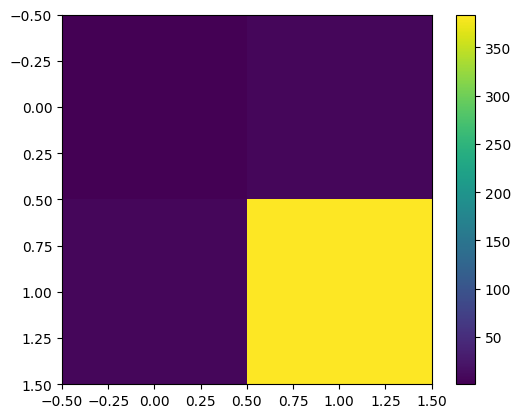

In [144]:
# test whether a small 2x2 kernel between w and nabla^4 w is positive definite
import numpy as np
import matplotlib.pyplot as plt
xtest = np.random.rand(2) # at a single point
Cov = np.array([
    [kernel2d(xtest, xtest), kernel2d_bilapl(xtest, xtest)],
    [kernel2d_bilapl(xtest, xtest), kernel2d_double_bilapl(xtest, xtest)]
])
# now get eigenvalues to see if pos definite
lam, phi = np.linalg.eig(Cov)
print(f"{lam=} {phi=}")
plt.imshow(Cov)
plt.colorbar()

num_interior=40 num_all=50
K11.shape=TensorShape([50, 50]) K12.shape=TensorShape([40, 50]) K22.shape=TensorShape([40, 40])
min_eigval=0.046154063 max_eigval=4623.2036


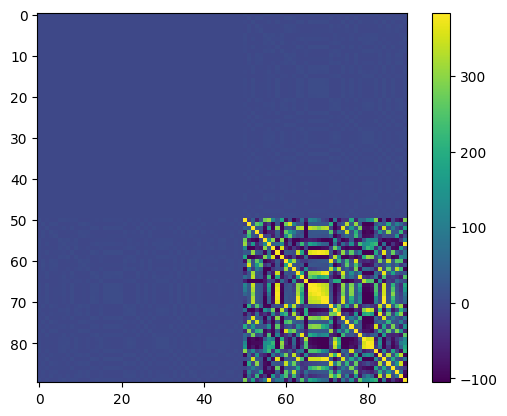

In [145]:
# compute the block matrix Sigma = [cov(w_int, w_int), cov(w_int, w_bndry), cov(w_int, nabla^4 w_int),
#                                   cov(w_bndry, w_int), cov(w_bndry, w_bndry), cov(w_bndry, nabla^4 w_bndry),
#                                   cov(nabla^4 w_int, w_int), cov(nabla^4 w_int, w_bndry), cov(nabla^4 w_int, nabla^4 w_int) ]
# not a function of theta..
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

theta_arr = tf.zeros(shape=(num_domain,1), dtype=DTYPE)
theta = tf.Variable(theta_arr, trainable=True, dtype=DTYPE)
# print(f"{theta=}")

# def kernel2d_12(x,xp):
#     return kernel1d_d2(x[0], xp[0], Lx) * kernel1d(x[1], xp[1], Ly)

# debugging
# num_interior = 5
# num_bndry = 3
# k31 = kernel2d_lapl(x_train[0,:], x_train[0,:])
# print(f"{k31=}")

n_block = 2 * num_interior + num_bndry

x_all = tf.concat([x_train, x_bndry], axis=0)
num_all = num_interior + num_bndry

# 1 - interior + bndry, 2 - nabla^4 w interior
_temp1 = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for i in range(num_all)] for j in range(num_all)])
K11 = tf.constant(_temp1, dtype=DTYPE)
_temp2 = np.array([[kernel2d_bilapl(x_train[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_interior)])
K12 = tf.constant(_temp2, dtype=DTYPE)
_temp3 = np.array([[kernel2d_double_bilapl(x_train[i,:], x_train[j,:]) for j in range(num_interior)] for i in range(num_interior)])
K22 = tf.constant(_temp3, dtype=DTYPE)

print(f"{num_interior=} {num_all=}")
print(f"{K11.shape=} {K12.shape=} {K22.shape=}")

_row1 = tf.constant(tf.concat([K11, tf.transpose(K12)], axis=1))
_row2 = tf.constant(tf.concat([K12, K22], axis=1))
Kblock_prereg = tf.concat([_row1, _row2], axis=0)
# print(f"{Kblock.shape=}")

# apply robust regularization w.r.t. the max eigenvalue, namely we add epsilon * I term to matrix
# where epsilon = alpha * lambda_max
alpha = 1e-5
eigvals = np.linalg.eigvalsh(Kblock_prereg)
max_eigval = np.max(eigvals)
eps = alpha * max_eigval

Kblock = tf.constant(Kblock_prereg + eps * tf.eye(n_block), dtype=DTYPE)

# can double check eigvals again for debugging to ensure still pos definite
# had issues where min_eigval = -1e-5, max_eigval = 1e3 and needed regularization to make 
# Sigma pos def. Note : cov matrices are always pos definite, so small neg eigvals is really soln error for some near zero.
# I double checked assembly and my kernel derivatives and those were all right, so regularization was the fix.

# printout eigenvalues for debugging
# eigvals = np.linalg.eigvalsh(Kblock)
# min_eigval = np.min(eigvals); max_eigval = np.max(eigvals)
# print(f"{min_eigval=} {max_eigval=}")

# show the matrix image to see if positive definite roughly
plt.imshow(Kblock)
plt.colorbar()

In [146]:
# construct rhs vec in order to invert K^-1 * f = ans
# so we solve K * ans = f = rhs

# constant vector part [w_{dOmega}, nabla^4 w] where nabla^4 w = -q / D
w_ext = tf.zeros(shape=(num_bndry,1), dtype=DTYPE)
print(f"{w_ext.shape=}")
nabla4_w = -q / D
nabla4_w2 = tf.reshape(nabla4_w, shape=(num_domain,1))
print(f"{nabla4_w2.shape=}")

_temp = tf.concat([w_ext, nabla4_w2], axis=0)
fixed_vec = tf.constant(_temp, dtype=DTYPE)

# print(f"{fixed_vec=}")

# w_interior points will be added later as trainable variables and we'll concatenate them together

w_ext.shape=TensorShape([10, 1])
nabla4_w2.shape=TensorShape([40, 1])


In [147]:
# test that we can solve a system correctly with tensorflow lu decomposition / cholesky before
# we use it in the optimization

# pick random values for w interior initially and rhs
w_int = tf.constant(np.random.rand(num_interior,1), dtype=DTYPE)
rhs = tf.concat([w_int, fixed_vec], axis=0)

K_lu = tf.linalg.lu(Kblock)
ans = tf.linalg.lu_solve(*K_lu, rhs=rhs)

residual = Kblock @ ans - rhs
print(f"{residual[:10,0]=}")

rel_res_norm = np.max(np.abs(residual)) / np.max(np.abs(rhs))
print(f"{rel_res_norm=}")


residual[:10,0]=<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 6.3031912e-06,  1.6987324e-06,  1.8477440e-06, -3.5762787e-07,
        4.0680170e-06,  4.9769878e-06, -3.8743019e-06,  4.1276217e-06,
       -1.9669533e-06,  7.7486038e-06], dtype=float32)>
rel_res_norm=0.0001190417


In [148]:
# do cholesky decomposition of Kblock = L L^T with constant before we actually do optimization (since this part is fixed and not a part of theta optimization)
# K_chol = tf.linalg.cholesky(Kblock)

# do lu decomposition of Kblock so we don't have to keep recomputing it
K_lu = tf.linalg.lu(Kblock)

In [150]:
# now optimize the theta parameter of interior w values
theta = tf.Variable(tf.zeros(shape=(num_domain,1), dtype=DTYPE), trainable=True)
# theta = [tf.Variable(t) for t in theta]
# print(f"{theta=}")
num_epochs = 2000
# num_epochs = 1

learning_rate = 1e-5 # can be much higher here?
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for epoch in range(num_epochs):
    # record the loss gradient
    with tf.GradientTape(persistent=True) as tape:
        w_full = tf.concat([theta, fixed_vec], axis=0)
        ans = tf.linalg.lu_solve(*K_lu, rhs=w_full)
        # print(f"{ans=}")
        # print(f"{w_full=}")

        # double check ans solves the system K_block * ans = w_full
        res = tf.matmul(Kblock, ans) - w_full
        abs_norm = np.max(np.abs(res))
        rel_res_norm = abs_norm / np.max(np.abs(w_full))
        # print(f"{res=}")
        # print(f"{abs_norm=} {rel_res_norm=}")
        # print(f"{np.linalg.norm(w_full)=} {np.linalg.norm(ans)=}")
        

        # fixed so loss no longer negative by regularizing kernel matrix
        loss = tf.tensordot(tf.transpose(w_full), ans, axes=1)
        # print(f"{loss=}")
        # print(f"{loss.shape=}")

        # scale loss by physics D otherwise divided by D^2 essentially
        # print(f"{D=}")
        loss *= 1e3 # *= D

    loss_gradient = tape.gradient(loss, theta)
    # print(f"{loss_gradient=}")

    # could change to Gauss-newton algorithm here instead.. would prob be better

    # gradient descent with adam optimizer
    optimizer.apply_gradients(
        [(loss_gradient, theta)]
    )
    del tape

    loss_val = loss.numpy()[0,0]
    print(f"{epoch=}\t{loss_val=}")

# print(f"{theta=}")

epoch=0	loss_val=0.00034900292
epoch=1	loss_val=0.00028009032
epoch=2	loss_val=0.00023966009
epoch=3	loss_val=0.0002206314
epoch=4	loss_val=0.00020969998
epoch=5	loss_val=0.0002024685
epoch=6	loss_val=0.00020079836
epoch=7	loss_val=0.00020350883
epoch=8	loss_val=0.00020673905
epoch=9	loss_val=0.00020805109
epoch=10	loss_val=0.00020745902
epoch=11	loss_val=0.00020511402
epoch=12	loss_val=0.00020126344
epoch=13	loss_val=0.00019697135
epoch=14	loss_val=0.0001935029
epoch=15	loss_val=0.00019141177
epoch=16	loss_val=0.00019036338
epoch=17	loss_val=0.00018972489
epoch=18	loss_val=0.00018913712
epoch=19	loss_val=0.00018852425
epoch=20	loss_val=0.00018787108
epoch=21	loss_val=0.00018719124
epoch=22	loss_val=0.00018653763
epoch=23	loss_val=0.00018595779
epoch=24	loss_val=0.00018550792
epoch=25	loss_val=0.00018524902
epoch=26	loss_val=0.00018513102
epoch=27	loss_val=0.00018497068
epoch=28	loss_val=0.00018464917
epoch=29	loss_val=0.00018424947
epoch=30	loss_val=0.0001839
epoch=31	loss_val=0.00018

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (400, 1)

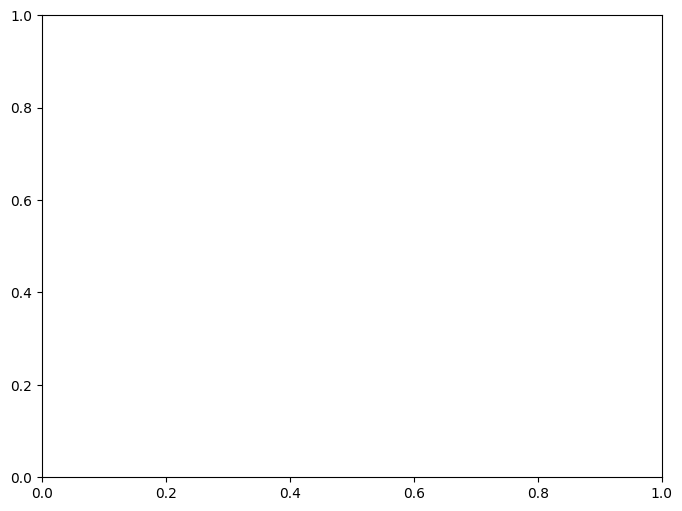

In [ ]:
# predict the values at a grid of points (a mesh) so we can view predicted contour of the solution
# using the mean interpolated from trained values
import numpy as np

n = 20
ngrid = n * n
_xgrid = np.linspace(0.0, a, n)
_ygrid = np.linspace(0.0, b, n)
X, Y = np.meshgrid(_xgrid, _ygrid)
xgrid = np.reshape(X, newshape=(ngrid,1))
ygrid = np.reshape(Y, newshape=(ngrid,1))
x_grid = np.concatenate([xgrid, ygrid], axis=1)

K_train = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_all)])
K_cross = np.array([[kernel2d(x_grid[i,:], x_all[j,:]) for j in range(num_all)] for i in range(ngrid)])

max_eigval = np.max(np.linalg.eigvalsh(K_train))
W_grid = K_cross @ np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), w_full[:num_all,:])
W = np.reshape(W_grid, newshape=(n, n))

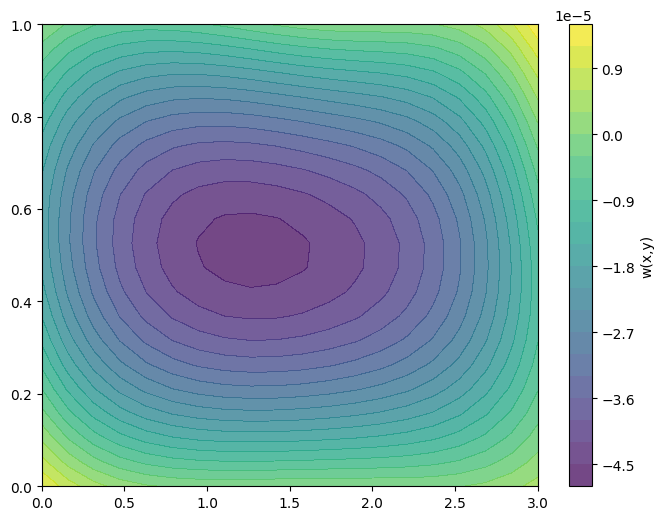

In [ ]:
import matplotlib.pyplot as plt
# now plot the predicted solution contour
plt.figure(figsize=(8, 6))
colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

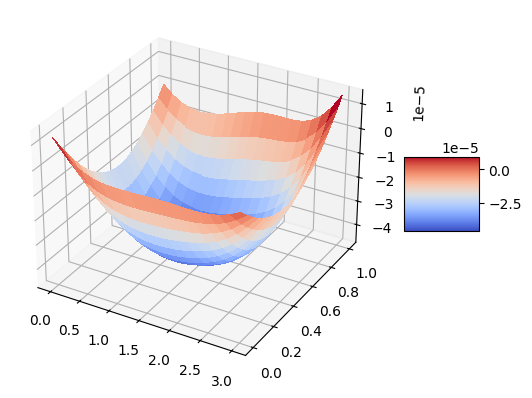

In [157]:
import matplotlib.pyplot as plt
from matplotlib import cm
# now plot the predicted solution surface in 3d
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
plt.show()